In [43]:
import pandas as pd

df_ = pd.read_csv("datafiles/mimic-iv-cohort.csv")
df_.head()

,subject_id,hadm_id,stay_id,first_careunit,last_careunit,intime,outtime,los,admittime,dischtime,...,creatinine,lactate,lactate_cat,bicarbonate,hemoglobin,sodium,potassium,glucose,platelet,log_treatment
0,17195991,23542772,38319097,Surgical Intensive Care Unit (SICU),Surgical Intensive Care Unit (SICU),2110-01-12T00:54:00Z,2110-01-14T22:07:39Z,2.884479,2110-01-11T22:47:00Z,2110-01-18T10:25:00Z,...,0.7,NaN,missing,23.0,11.6,145.0,2.8,116.0,247.0,3.108574
1,12770182,20446666,34901199,Medical Intensive Care Unit (MICU),Medical Intensive Care Unit (MICU),2110-01-18T17:47:47Z,2110-01-20T22:25:09Z,2.192616,2110-01-18T17:46:00Z,2110-01-21T16:30:00Z,...,0.8,NaN,missing,28.0,14.8,142.0,4.2,114.0,300.0,2.757537
2,15173979,28605254,33198006,Trauma SICU (TSICU),Trauma SICU (TSICU),2110-02-02T20:55:57Z,2110-02-04T16:54:51Z,1.832569,2110-02-02T18:56:00Z,2110-02-08T18:30:00Z,...,1.8,1.0,<2,23.0,15.0,137.0,4.9,115.0,171.0,3.263041
3,18425495,25117070,35090086,Medical Intensive Care Unit (MICU),Medical Intensive Care Unit (MICU),2110-02-03T18:04:00Z,2110-02-07T00:30:01Z,3.268067,2110-02-03T16:46:00Z,2110-02-09T14:08:00Z,...,1.2,NaN,missing,17.0,10.0,143.0,3.4,103.0,116.0,2.607134
4,10582595,20690213,33235984,Surgical Intensive Care Unit (SICU),Trauma SICU (TSICU),2110-02-09T22:11:00Z,2110-02-13T17:33:51Z,3.807535,2110-02-09T20:41:00Z,2110-02-17T15:40:00Z,...,0.7,NaN,missing,28.0,NaN,134.0,4.1,135.0,NaN,2.919146


In [11]:
df_.columns

Index(['subject_id', 'hadm_id', 'stay_id', 'first_careunit', 'last_careunit',
       'intime', 'outtime', 'los', 'admittime', 'dischtime', 'deathtime',
       'admission_type', 'admission_location', 'discharge_location',
       'insurance', 'language', 'marital_status', 'ethnicity', 'edregtime',
       'edouttime', 'hospital_expire_flag', 'total.stays', 'age', 'gender',
       'ed_icu.time.diff', 'score', 'chf', 'esrd', 'chf.esrd', 'sepsis.only',
       'subgroup', 'day1', 'patientweight', 'treatment', 'vaso', 'norep',
       'pressor', 'ventilation_status', 'sofa_start', 'sofa_end', 'sofa_delta',
       'sofa_24hours', 'DNI', 'temperature', 'heart_rate', 'wbc', 'creatinine',
       'lactate', 'lactate_cat', 'bicarbonate', 'hemoglobin', 'sodium',
       'potassium', 'glucose', 'platelet', 'log_treatment'],
      dtype='object')

In [44]:
time_converter = lambda ts: pd.to_datetime(ts.str.strip(), format="%Y-%m-%dT%H:%M:%SZ")
time_cols = ["outtime", "intime", "admittime", "dischtime", "deathtime", "edregtime", "edouttime"]
for col in time_cols:
    df_[col] = time_converter(df_[col]) 


df_.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14798 entries, 0 to 14797
Data columns (total 56 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   subject_id            14798 non-null  int64         
 1   hadm_id               14798 non-null  int64         
 2   stay_id               14798 non-null  int64         
 3   first_careunit        14798 non-null  object        
 4   last_careunit         14798 non-null  object        
 5   intime                14798 non-null  datetime64[ns]
 6   outtime               14798 non-null  datetime64[ns]
 7   los                   14798 non-null  float64       
 8   admittime             14798 non-null  datetime64[ns]
 9   dischtime             14798 non-null  datetime64[ns]
 10  deathtime             2520 non-null   datetime64[ns]
 11  admission_type        14798 non-null  object        
 12  admission_location    14798 non-null  object        
 13  discharge_locati

# Check the messy columns

In [49]:

import numpy as np
analysis_df_ = df_.select_dtypes(include='object').applymap(lambda x: not(np.isreal(x)))
analysis_df_.all(axis=0)

first_careunit         True
last_careunit          True
admission_type         True
admission_location     True
discharge_location    False
insurance              True
language               True
marital_status        False
ethnicity              True
gender                 True
subgroup               True
pressor                True
ventilation_status     True
lactate_cat            True
dtype: bool

# Define the covariates and dataframes

In [53]:
outcomes = ["hospital_expire_flag"]  # does he die or not
cohort = ["chf", "esrd"]  # dummies variable
covariates = [
    "age",
    "gender",
    "temperature",
    "heart_rate",
    "wbc",
    "creatinine",
    "lactate_cat",
    "bicarbonate",
    "hemoglobin",
    "sodium",
    "potassium",
    "glucose",
    "platelet",
]


df_y = df_.loc[:, outcomes]
df_x = df_.loc[:, covariates]

In [168]:
from IPython.display import Markdown


def warning_(warning_list):
    if warning_list:
        flag = ", ".join(warning_list)
        display(
            Markdown(
                'Frozen features <span style="color: #ff0000">{}</span> are not in line with this test.'.format(
                    flag
                )
            )
        )
    else:
        display(Markdown('<span style="color: green">All of the covariates passed the test</span>'))

# First look of the data

Input 
 
 
 
 age 
 gender 
 temperature 
 heart_rate 
 wbc 
 creatinine 
 lactate_cat 
 bicarbonate 
 hemoglobin 
 sodium 
 potassium 
 glucose 
 platelet 
 
 
 
 
 14793 
 75 
 M 
 37.72 
 109.0 
 5.5 
 1.3 
 missing 
 24.0 
 9.1 
 136.0 
 5.9 
 190.0 
 142.0 
 
 
 14794 
 49 
 F 
 36.72 
 80.0 
 3.7 
 0.8 
 <2 
 22.0 
 8.9 
 145.0 
 3.5 
 81.0 
 227.0 
 
 
 14795 
 86 
 M 
 36.44 
 160.0 
 7.3 
 1.8 
 >4 
 26.0 
 8.7 
 138.0 
 4.4 
 165.0 
 90.0 
 
 
 14796 
 67 
 M 
 36.33 
 85.0 
 15.0 
 4.8 
 <2 
 14.0 
 8.8 
 140.0 
 5.5 
 224.0 
 295.0 
 
 
 14797 
 66 
 F 
 36.78 
 85.0 
 20.4 
 1.2 
 >4 
 17.0 
 10.0 
 142.0 
 3.4 
 207.0 
 446.0 
 
 
 Outputs 
 
 
 
 hospital_expire_flag 
 
 
 
 
 14793 
 0 
 
 
 14794 
 1 
 
 
 14795 
 1 
 
 
 14796 
 0 
 
 
 14797 
 0

<AxesSubplot:title={'center':'Distribution of deaths (1)'}, ylabel='None'>

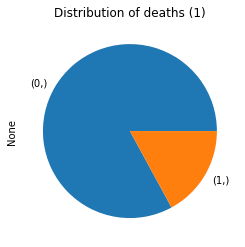

In [115]:
### ???????????????why you don't add the missing values fullfill here before this step?????????????????????????

from IPython.display import display_html
from itertools import chain, cycle


def display_side_by_side(*args, titles=cycle([""])):
    html_str = ""
    for df, title in zip(args, chain(titles, cycle(["</br>"]))):
        html_str += '<th style="text-align:center"><td style="vertical-align:top">'
        html_str += f"<h2>{title}</h2>"
        html_str += df.to_html().replace("table", 'table style="display:inline"')
        html_str += "</td></th>"
    display_html(html_str, raw=True)


display_side_by_side(df_x.tail(5), df_y.tail(5), titles=["Input", "Outputs"])
df_y.value_counts().plot.pie(title="Distribution of deaths (1)")

# Check the number of missing data per column

In [116]:
df_valid_count = df_x.count()

keep_list_ = (df_valid_count > 0.88 * df_valid_count.max()).tolist()
col_ = [col for index, col in enumerate(list(df_x.columns)) if keep_list_[index]]
warning_([col for col in df_x.columns if col not in col_])
#print("{} columns kept ouf of {}".format(len(col_), len(df_x.columns)))
#df_x = df_x.loc[:,col_]

Frozen features <span style="color: #ff0000">wbc, hemoglobin, platelet</span> are not in line with this test.

# Remove unique values features

In [130]:
(df_x.loc[:,df_x.dtypes=="float64"].nunique()/len(df_x)).sort_values()

rate_lower_bound =  0

stat_ = ((df_x.nunique()/len(df_x))>rate_lower_bound)
select_ = [col for col in df_x.columns if stat_[col]]

select__ = [col for col in df_x.columns if col in select_]
print("{} columns kept ouf of {}".format(len(select__),len(df_x.columns)))

warning_([col for col in select__ if col not in select_])
#df_x = df_x[select__]

13 columns kept ouf of 13


<span style="color: green">All of the covariates passed the test</span>

# Remove features with a major part of same values (not usable for ML models)

In [142]:
print(
    {
        col: df_x.loc[:, df_x.dtypes == "float64"][col].value_counts().max() / len(df_x)
        for col in df_x.loc[:, df_x.dtypes == "float64"].columns
    }
)

rate_lower_bound = 0.4

filtered_columns_ = [
    col
    for col in df_x.loc[:, df_x.dtypes == "float64"].columns
    if df_x.loc[:, df_x.dtypes == "float64"][col].value_counts().max() / len(df_x)
    < rate_lower_bound
]
warning_([col for col in df_x.loc[:, df_x.dtypes == "float64"] if col not in filtered_columns_])

# filter_history['repeated_values'] = set([col for col in df_x if col not in filtered_columns__])
print("{} features kept out of {}".format(len(filtered_columns_), len(df_x.loc[:, df_x.dtypes == "float64"].columns)))

{'temperature': 0.042100283822138124, 'heart_rate': 0.02371942154345182, 'wbc': 0.00750101365049331, 'creatinine': 0.07703743749155291, 'bicarbonate': 0.0794026219759427, 'hemoglobin': 0.01608325449385052, 'sodium': 0.07919989187728071, 'potassium': 0.054737126638734965, 'glucose': 0.010068928233545073, 'platelet': 0.0050006757669955396}


<span style="color: green">All of the covariates passed the test</span>

10 features kept out of 10


# Lets check the correlation between selected features and  remove unrequired features with a greedy, DP algorithm on features correlated with more than 0.9

In [143]:
import numpy as np

take=10

corr_matrix = df_x.corr().abs()

#the matrix is symmetric so we need to extract upper triangle matrix without diagonal (k = 1)

sol = (corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
                  .stack()
                  .sort_values(ascending=False))
print(f"Top {take} correlated features \t\t     Pearson")
print(sol[:take])

Top 10 correlated features 		     Pearson
creatinine   potassium      0.310464
temperature  heart_rate     0.248070
creatinine   bicarbonate    0.218335
wbc          platelet       0.182803
age          heart_rate     0.165583
sodium       potassium      0.163140
bicarbonate  glucose        0.158210
creatinine   hemoglobin     0.142364
bicarbonate  potassium      0.134199
             sodium         0.118498
dtype: float64


In [145]:
df_corr = (corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))>0.9).stack().sort_values(ascending=False).reset_index()
dict_ = df_corr[df_corr[df_corr.columns[-1]]==True][['level_0','level_1']].to_dict('index')
set_ = set(map(lambda x: frozenset(x.values()), dict_.values())) 

from data.analysisTool import remove_features


initial_features = set(df_x.columns)
features_to_remove = remove_features(set_)
print("Kept {} out of {} features from the first correlation selection".format(len(initial_features)-len(features_to_remove),len(initial_features)))

new_features = initial_features.difference(*list(features_to_remove))
new_features_ = [col for col in df_x.columns if col in new_features or col in frozens]

warning_([col for col in new_features_ if col not in new_features])
df_x = df_x.loc[:,new_features_]

Kept 13 out of 13 features from the first correlation selection


<span style="color: green">All of the covariates passed the test</span>

# Correlation Based feature selection

In [146]:
from data.analysisTool import cfs
import pprint

cfs_ = {output: list(zip(*cfs(df_x ,df_y[output], min_features=len(df_x.columns)-1))) for output in df_y.columns}

Added heart_rate: : 13features [08:57, 41.37s/features]                


<span style="color: green">Recommended subset is </span> ['bicarbonate', 'wbc', 'lactate_cat', 'creatinine', 'sodium', 'temperature', 'potassium', 'glucose']

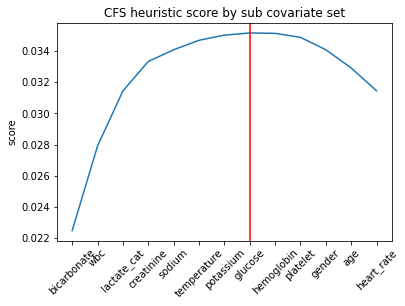

In [172]:
import matplotlib.pyplot as plt

res = next(iter(cfs_.values()))
x, labels = [x[1] for x in res], [x[0] for x in res]
plt.plot(x)
plt.xticks(range(0, len(res)), labels, rotation=45)
plt.ylabel("score")
plt.axvline(x=x.index(max(x)), color="red")
plt.title("CFS heuristic score by sub covariate set")

display(Markdown('<span style="color: green">Recommended subset is </span> {}'.format(labels[:x.index(max(x))+1])))

